In [2]:
# %% 
# Imports e configurações globais
import math, random, os, json, time
from typing import Tuple, List, Dict, Any

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [3]:
# %%
import numpy as np
import math
import random
import matplotlib.pyplot as plt

# ---------- Padrões geométricos básicos ----------

def gen_concentric_rings(center=(0.0,0.0), n=200, radii=(1.0,), radii_frac=(1.0,), noise=0.1):
    """
    Gera pontos em anéis concêntricos. radii: tuple de raios de base.
    radii_frac: multiplicador aleatório por ponto (variação do raio).
    """
    cx, cy = center
    pts = []
    for r in radii:
        # gerar aproximadamente n * weight pontos por anel (balanceamos pelo radii_frac)
        count = max(1, int(n * (r / (sum(radii) + 1e-9))))
        th = np.random.uniform(0, 2*math.pi, size=count)
        rf = np.random.normal(loc=r, scale=(r*0.05), size=count)  # pequena variação
        x = cx + rf * np.cos(th) + np.random.normal(scale=noise, size=count)
        y = cy + rf * np.sin(th) + np.random.normal(scale=noise, size=count)
        pts.append(np.stack([x,y], axis=1))
    return np.vstack(pts).astype(np.float32)

def gen_radial_spokes(center=(0,0), n=200, n_spokes=8, radius=3.0, noise=0.12):
    """
    Gera pontos ao longo de 'raios' (spokes): bom para classes que têm 'direção' consistente.
    """
    cx, cy = center
    pts=[]
    per_spoke = max(2, n // n_spokes)
    for s in range(n_spokes):
        theta = 2*math.pi * s / n_spokes + np.random.normal(scale=0.02)
        r = np.random.uniform(low=0.1*radius, high=radius, size=per_spoke)
        x = cx + r * np.cos(theta) + np.random.normal(scale=noise, size=per_spoke)
        y = cy + r * np.sin(theta) + np.random.normal(scale=noise, size=per_spoke)
        pts.append(np.stack([x,y], axis=1))
    return np.vstack(pts).astype(np.float32)

def gen_grid_blob(center=(0,0), n=200, grid_scale=0.4, noise=0.15):
    """
    Gera um blob onde os pontos são principalmente em torno de um pequeno grid local,
    simulando micro-estrutura repetitiva (ex: padrões texturais).
    """
    cx, cy = center
    # criar um pequeno grid de sub-centros
    gx = np.random.randint(2,5)
    gy = np.random.randint(2,5)
    xs = np.linspace(cx - grid_scale, cx + grid_scale, gx)
    ys = np.linspace(cy - grid_scale, cy + grid_scale, gy)
    centers = np.array(np.meshgrid(xs, ys)).reshape(2, -1).T
    pts=[]
    per_center = max(1, n // len(centers))
    for c in centers:
        x = np.random.normal(loc=c[0], scale=noise, size=per_center)
        y = np.random.normal(loc=c[1], scale=noise, size=per_center)
        pts.append(np.stack([x,y], axis=1))
    return np.vstack(pts).astype(np.float32)

def gen_oriented_ellipse(center=(0,0), n=200, a=1.0, b=0.4, angle=0.0, noise=0.1):
    """
    Gera elipse orientada (boa para dados com anisotropia consistente).
    """
    cx, cy = center
    th = np.random.uniform(0, 2*math.pi, size=n)
    r_x = a * np.cos(th)
    r_y = b * np.sin(th)
    R = np.array([[math.cos(angle), -math.sin(angle)], [math.sin(angle), math.cos(angle)]])
    pts = np.stack([r_x, r_y], axis=1) @ R.T
    pts[:,0] += cx + np.random.normal(scale=noise, size=n)
    pts[:,1] += cy + np.random.normal(scale=noise, size=n)
    return pts.astype(np.float32)

# ---------- Wrapper para um padrão por classe ----------
def gen_class_pattern(pattern_type, center, samples, pattern_params):
    """
    Escolhe gerador baseado em pattern_type.
    pattern_params é dict com keys específicas para cada gerador.
    """
    if pattern_type == 'rings':
        radii = pattern_params.get('radii', (0.8, 1.6))
        return gen_concentric_rings(center=center, n=samples, radii=radii, noise=pattern_params.get('noise', 0.08))
    elif pattern_type == 'spokes':
        return gen_radial_spokes(center=center, n=samples, n_spokes=pattern_params.get('n_spokes',8),
                                 radius=pattern_params.get('radius',3.0), noise=pattern_params.get('noise', 0.12))
    elif pattern_type == 'grid':
        return gen_grid_blob(center=center, n=samples, grid_scale=pattern_params.get('grid_scale', 0.4),
                             noise=pattern_params.get('noise', 0.12))
    elif pattern_type == 'ellipse':
        return gen_oriented_ellipse(center=center, n=samples, a=pattern_params.get('a',1.2),
                                    b=pattern_params.get('b',0.45), angle=pattern_params.get('angle',0.0),
                                    noise=pattern_params.get('noise', 0.1))
    else:
        # fallback gaussian
        cx, cy = center
        pts = np.random.normal(loc=(cx, cy), scale=pattern_params.get('noise', 0.6), size=(samples,2))
        return pts.astype(np.float32)

In [4]:
# --- make_patterned_clusters: 'varied' (mix families) ---
def make_patterned_clusters(n_classes=12, samples_per_class=120, radius=8.0, pattern='varied',
                             pattern_types=None, separation_noise=0.2, outlier_frac=0.03, rng_seed=None):
    """
    pattern: 'varied' -> each class randomly gets a family type
             'clear' is not used here (use fixed_family for clear)
    """
    if rng_seed is not None:
        np.random.seed(rng_seed)
        random.seed(rng_seed)
    if pattern_types is None:
        pattern_types = ['rings','spokes','grid','ellipse']
    centers=[]
    for k in range(n_classes):
        angle = 2 * math.pi * k / n_classes + np.random.normal(0, 0.15)
        cx = math.cos(angle) * (radius + np.random.normal(0, separation_noise))
        cy = math.sin(angle) * (radius + np.random.normal(0, separation_noise))
        centers.append((cx, cy))
    X_list=[]; y_list=[]
    for idx, center in enumerate(centers):
        chosen = random.choice(pattern_types)
        if chosen == 'spokes':
            params = {'n_spokes': random.randint(3,12),
                      'radius': random.uniform(1.5,4.0),
                      'noise': random.uniform(0.04,0.25)}
        elif chosen == 'rings':
            k = random.randint(1,3)
            base = random.uniform(0.6,1.8)
            radii = tuple(base * (1 + i*0.8) for i in range(k))
            params = {'radii': radii, 'noise': random.uniform(0.04,0.22)}
        elif chosen == 'ellipse':
            params = {'a': random.uniform(0.8,2.0), 'b': random.uniform(0.2,1.2), 'angle': random.uniform(0,math.pi),
                      'noise': random.uniform(0.05,0.25)}
        elif chosen == 'grid':
            params = {'grid_scale': random.uniform(0.2,0.8), 'noise': random.uniform(0.05,0.25)}
        else:
            # Gaussian / No Pattern
            params = {'noise': random.uniform(0.4, 0.8)} # um pouco mais espalhado para ser um blob normal

        pts = gen_class_pattern(chosen, center, samples_per_class, params)
        # local outliers
        n_out = int(outlier_frac * samples_per_class)
        if n_out > 0:
            out = np.random.uniform(low=[center[0]-6, center[1]-6], high=[center[0]+6, center[1]+6], size=(n_out,2)).astype(np.float32)
            if pts.shape[0] >= n_out:
                pts[-n_out:] = out
            else:
                pts = np.vstack([pts, out])
        X_list.append(pts.astype(np.float32))
        y_list += [idx] * pts.shape[0]
    X = np.vstack(X_list).astype(np.float32)
    y = np.array(y_list, dtype=np.int64)
    return X, y

In [5]:
# --- make_chaotic_clusters: Random placement (no ring) ---
def make_chaotic_clusters(n_classes=12, samples_per_class=120, box_size=10.0, min_dist=2.0,
                          pattern_types=None, outlier_frac=0.03, rng_seed=None):
    """
    Gera clusters com centros posicionados aleatoriamente em uma caixa [-box_size, box_size],
    respeitando uma distância mínima (min_dist) para evitar sobreposição total.
    Isso quebra a estrutura de 'anel' dos datasets anteriores.
    """
    if rng_seed is not None:
        np.random.seed(rng_seed)
        random.seed(rng_seed)
    
    if pattern_types is None:
        pattern_types = ['gaussian'] # Default to simple blobs if not specified

    # 1. Gerar centros aleatórios com rejeição
    centers = []
    attempts = 0
    max_attempts = 2000
    while len(centers) < n_classes and attempts < max_attempts:
        cx = np.random.uniform(-box_size, box_size)
        cy = np.random.uniform(-box_size, box_size)
        # Check distance to existing
        if all(math.hypot(cx-ox, cy-oy) >= min_dist for ox, oy in centers):
            centers.append((cx, cy))
        attempts += 1
    
    if len(centers) < n_classes:
        print(f"Warning: Could only place {len(centers)}/{n_classes} centers with min_dist={min_dist}. Box might be too small.")

    X_list=[]; y_list=[]
    for idx, center in enumerate(centers):
        chosen = random.choice(pattern_types)
        
        # Configuração de parâmetros (similar ao make_patterned_clusters)
        if chosen == 'spokes':
            params = {'n_spokes': random.randint(3,12), 'radius': random.uniform(1.5,3.5), 'noise': random.uniform(0.05,0.2)}
        elif chosen == 'rings':
            k = random.randint(1,2)
            radii = tuple(random.uniform(0.5, 1.0) * (1 + i*0.8) for i in range(k))
            params = {'radii': radii, 'noise': random.uniform(0.05,0.15)}
        elif chosen == 'ellipse':
            params = {'a': random.uniform(0.8,1.8), 'b': random.uniform(0.3,1.0), 'angle': random.uniform(0,math.pi), 'noise': random.uniform(0.05,0.2)}
        elif chosen == 'grid':
            params = {'grid_scale': random.uniform(0.3,0.7), 'noise': random.uniform(0.05,0.2)}
        else:
            # Gaussian default
            params = {'noise': random.uniform(0.4, 0.7)}

        pts = gen_class_pattern(chosen, center, samples_per_class, params)
        
        # Outliers
        n_out = int(outlier_frac * samples_per_class)
        if n_out > 0:
            # Outliers globais na caixa
            out = np.random.uniform(low=-box_size-2, high=box_size+2, size=(n_out,2)).astype(np.float32)
            if pts.shape[0] >= n_out:
                pts[-n_out:] = out
            else:
                pts = np.vstack([pts, out])
                
        X_list.append(pts.astype(np.float32))
        y_list += [idx] * pts.shape[0]

    X = np.vstack(X_list).astype(np.float32)
    y = np.array(y_list, dtype=np.int64)
    return X, y

In [6]:
# %%
import numpy as np, math, random

def make_patterned_clusters_fixed_family(n_classes=8, samples_per_class=150, radius=6.0,
                                         family='spokes', family_variation=True,
                                         separation_noise=0.15, outlier_frac=0.03, rng_seed=None):
    """
    Gera clusters onde TODAS as classes pertencem à MESMA family (family='spokes'|'rings'|'grid'|'ellipse').
    family_variation: se True, aplica pequenas variações paramétricas por classe (ex: n_spokes, radius jitter).
    """
    if rng_seed is not None:
        np.random.seed(rng_seed)
        random.seed(rng_seed)
    centers = []
    for k in range(n_classes):
        angle = 2 * math.pi * k / n_classes + np.random.normal(0, 0.12)
        cx = math.cos(angle) * (radius + np.random.normal(0, separation_noise))
        cy = math.sin(angle) * (radius + np.random.normal(0, separation_noise))
        centers.append((cx, cy))

    X_list = []; y_list = []
    for idx, center in enumerate(centers):
        # define params depending on family with small per-class jitter if family_variation=True
        if family == 'spokes':
            base_spokes = 6
            n_spokes = base_spokes + (idx % 4) if family_variation else base_spokes
            params = {'n_spokes': max(3, n_spokes),
                      'radius': 2.2 + (idx % 3) * 0.4 if family_variation else 2.8,
                      'noise': 0.06 + (idx % 3) * 0.02}
            pts = gen_radial_spokes(center=center, n=samples_per_class,
                                    n_spokes=params['n_spokes'],
                                    radius=params['radius'],
                                    noise=params['noise'])
        elif family == 'rings':
            base = 0.8
            r1 = base + (idx % 3) * 0.25 if family_variation else base
            r2 = r1 * (1.6 + ((idx+1)%2)*0.2)
            params = {'radii': (r1, r2), 'noise': 0.05 + (idx % 4) * 0.01}
            pts = gen_concentric_rings(center=center, n=samples_per_class,
                                       radii=params['radii'], noise=params['noise'])
        elif family == 'ellipse':
            a = 1.0 + (idx % 3) * 0.25 if family_variation else 1.2
            b = 0.35 + ((idx+1) % 3) * 0.15 if family_variation else 0.45
            ang = (idx * 0.35) % math.pi if family_variation else 0.0
            params = {'a': a, 'b': b, 'angle': ang, 'noise': 0.06}
            pts = gen_oriented_ellipse(center=center, n=samples_per_class,
                                      a=params['a'], b=params['b'], angle=params['angle'],
                                      noise=params['noise'])
        elif family == 'grid':
            grid_scale = 0.25 + (idx % 3) * 0.08 if family_variation else 0.3
            params = {'grid_scale': grid_scale, 'noise': 0.06}
            pts = gen_grid_blob(center=center, n=samples_per_class, grid_scale=params['grid_scale'],
                                noise=params['noise'])
        else:
            # fallback gaussian
            pts = np.random.normal(loc=center, scale=0.6, size=(samples_per_class,2)).astype(np.float32)

        # outliers local
        n_out = int(outlier_frac * samples_per_class)
        if n_out > 0:
            out = np.random.uniform(low=[center[0]-6, center[1]-6], high=[center[0]+6, center[1]+6], size=(n_out,2)).astype(np.float32)
            if pts.shape[0] >= n_out:
                pts[-n_out:] = out
            else:
                pts = np.vstack([pts, out])

        X_list.append(pts.astype(np.float32))
        y_list += [idx] * pts.shape[0]

    X = np.vstack(X_list).astype(np.float32)
    y = np.array(y_list, dtype=np.int64)
    return X, y

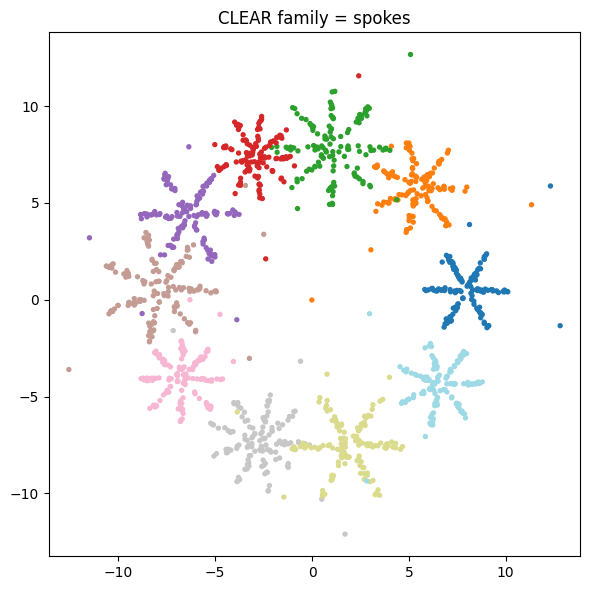

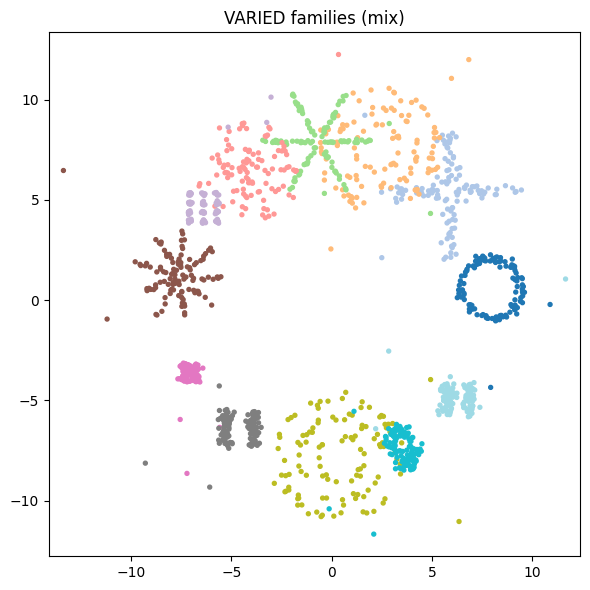

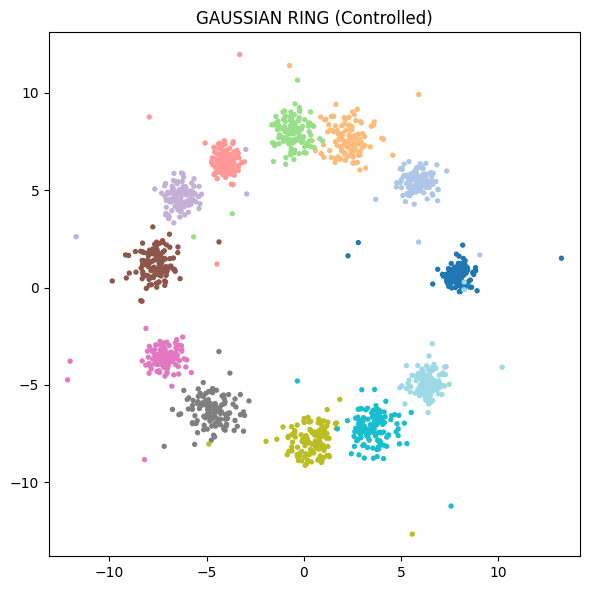

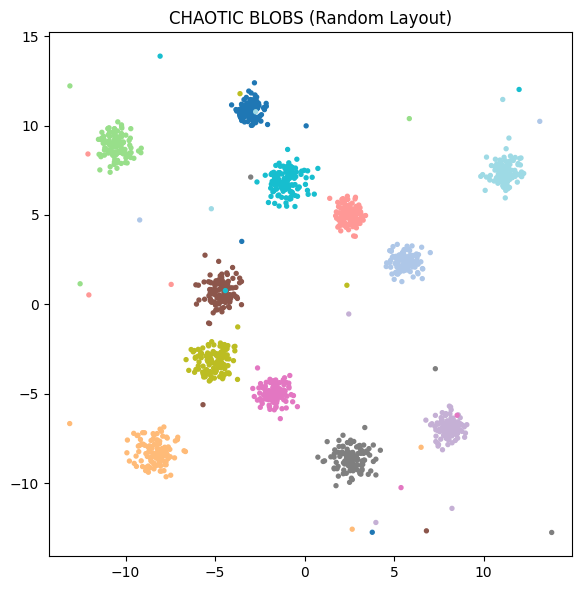

In [7]:
# %%
# Função de plot simples (reusa plot_2d_colored do notebook se já existir)
def plot_preview(X, y, title='preview', cmap='tab20'):
    plt.figure(figsize=(6,6))
    plt.scatter(X[:,0], X[:,1], c=y, s=8, cmap=cmap)
    plt.title(title)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# --- EXEMPLOS DE USO ---
# 1) Clear family: ALL spokes
X_spokes, y_spokes = make_patterned_clusters_fixed_family(n_classes=10, samples_per_class=140, radius=8.0,
                                                          family='spokes', family_variation=True, rng_seed=SEED)
plot_preview(X_spokes, y_spokes, title='CLEAR family = spokes')

# 2) Varied family (mix)
X_varied, y_varied = make_patterned_clusters(n_classes=12, samples_per_class=120, pattern='varied', rng_seed=SEED)
plot_preview(X_varied, y_varied, title='VARIED families (mix)')

# 3) Gaussian Ring (Antigo "No Pattern")
# Blobs Gaussianos simples, mas organizados em anel
X_g_ring, y_g_ring = make_patterned_clusters(n_classes=12, samples_per_class=120, pattern='varied', 
                                             pattern_types=['gaussian'], rng_seed=SEED)
plot_preview(X_g_ring, y_g_ring, title='GAUSSIAN RING (Controlled)')

# 4) Chaotic Blobs (Novo "Caótico")
# Blobs Gaussianos, mas posicionados aleatoriamente (sem anel)
X_chaotic, y_chaotic = make_chaotic_clusters(n_classes=12, samples_per_class=120, box_size=12.0, min_dist=3.0,
                                             pattern_types=['gaussian'], rng_seed=SEED)
plot_preview(X_chaotic, y_chaotic, title='CHAOTIC BLOBS (Random Layout)')

In [ ]:
# %%
# Tenta importar seu módulo; se não, fornece fallbacks (aproximações).
try:
    from cavl_doc.modules.losses import build_loss, LOSS_REGISTRY
    print('Using project losses:', list(LOSS_REGISTRY.keys()))
except Exception as e:
    print('Could not import project loss module — using fallbacks. Reason:', e)
    LOSS_REGISTRY = {}
    # Fallback ArcFace approx (simplificado)
    class ArcFaceLossSimple(nn.Module):
        def __init__(self, in_features=16, num_classes=8, s=30.0, m=0.5, **kwargs):
            super().__init__()
            self.s = s; self.m = m
            self.weight = nn.Parameter(torch.randn(num_classes, in_features))
        def _get_logits(self, embeddings, labels=None):
            emb = F.normalize(embeddings, dim=1)
            w = F.normalize(self.weight, dim=1)
            cosine = F.linear(emb, w)
            # NOTE: simplificado: não aplica cos(theta+m) exatamente (suficiente para comparar comportamento)
            return cosine * self.s
        def forward(self, embeddings, labels):
            logits = self._get_logits(embeddings)
            return F.cross_entropy(logits, labels.long())

    class ExpFaceLossSimple(nn.Module):
        def __init__(self, in_features=16, num_classes=8, s=30.0, m=0.7, **kwargs):
            super().__init__()
            self.s = s; self.m = m
            self.weight = nn.Parameter(torch.randn(num_classes, in_features))
        def _get_logits(self, embeddings, labels=None):
            emb = F.normalize(embeddings, dim=1)
            w = F.normalize(self.weight, dim=1)
            cosine = F.linear(emb, w).clamp(-1+1e-7, 1-1e-7)
            theta = torch.acos(cosine)
            theta_m = torch.pow(theta / math.pi, self.m) * math.pi
            cosine_m = torch.cos(theta_m)
            return cosine_m * self.s
        def forward(self, embeddings, labels):
            logits = self._get_logits(embeddings)
            return F.cross_entropy(logits, labels.long())

    class ElasticExpFaceSimple(nn.Module):
        def __init__(self, in_features=16, num_classes=8, s=30.0, m=0.7, std=0.05, **kwargs):
            super().__init__()
            self.s = s; self.m = m; self.std = std
            self.weight = nn.Parameter(torch.randn(num_classes, in_features))
        def _get_logits(self, embeddings, labels=None):
            emb = F.normalize(embeddings, dim=1)
            w = F.normalize(self.weight, dim=1)
            cosine = F.linear(emb, w).clamp(-1+1e-7, 1-1e-7)
            theta = torch.acos(cosine)
            m_rand = torch.normal(mean=self.m, std=self.std, size=cosine.size(), device=cosine.device)
            theta_m = torch.pow(theta / math.pi, m_rand) * math.pi
            cosine_m = torch.cos(theta_m)
            return cosine_m * self.s
        def forward(self, embeddings, labels):
            logits = self._get_logits(embeddings)
            return F.cross_entropy(logits, labels.long())

    LOSS_REGISTRY = {
        'arcface': ArcFaceLossSimple,
        'expface': ExpFaceLossSimple,
        'elastic_expface': ElasticExpFaceSimple
    }
    def build_loss(name, **kwargs):
        if name not in LOSS_REGISTRY:
            raise ValueError('Unknown loss ' + name)
        return LOSS_REGISTRY[name](**kwargs)

In [ ]:
# %%
# Simple encoder (MLP) com dim de embedding configurável
class SimpleEncoder(nn.Module):
    def __init__(self, in_dim=2, emb_dim=16, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, emb_dim)
        )
    def forward(self, x):
        return self.net(x)

# Trainers
from torch.utils.data import DataLoader, TensorDataset

# %%
# Substitua a função train_classification existente por esta versão (aceita loss_kwargs).
# Cole e execute esta célula antes de chamar run_experiment(...)
from torch.utils.data import DataLoader, TensorDataset

def train_classification(encoder: nn.Module,
                         loss_name: str,
                         X_tr: np.ndarray,
                         y_tr: np.ndarray,
                         epochs=30,
                         lr=1e-3,
                         emb_dim=16,
                         batch_size=256,
                         loss_kwargs: dict = None,
                         verbose=True):
    """
    Treina encoder usando a loss especificada.
    Agora aceita loss_kwargs: dict que será encaminhado ao construir a loss via build_loss(..., **loss_kwargs).
    Retorna: (encoder_trained, loss_module, classifier_or_None, history)
    """
    if loss_kwargs is None:
        loss_kwargs = {}

    encoder = encoder.to(device)
    num_classes = int(len(np.unique(y_tr)))

    # Constrói a loss passando os kwargs (se build_loss suporta)
    loss_module = build_loss(
        loss_name,
        in_features=emb_dim,
        num_classes=num_classes,
        **loss_kwargs
    ).to(device)

    # detecta se a loss tem parâmetro interno 'weight' (ArcFace-like)
    has_weight = any('weight' in n for n, _ in loss_module.named_parameters())

    if not has_weight:
        classifier = nn.Linear(emb_dim, num_classes).to(device)
        params = list(encoder.parameters()) + list(classifier.parameters()) + list(loss_module.parameters())
    else:
        classifier = None
        params = list(encoder.parameters()) + list(loss_module.parameters())

    opt = optim.Adam(params, lr=lr)
    loader = DataLoader(TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr)), batch_size=batch_size, shuffle=True)

    history = []
    for ep in range(epochs):
        encoder.train()
        running = 0.0
        cnt = 0
        for bx, by in loader:
            bx = bx.to(device); by = by.to(device)
            opt.zero_grad()
            emb = encoder(bx)
            if classifier is not None:
                logits = classifier(emb)
                loss = F.cross_entropy(logits, by.long())
            else:
                # loss_module espera (embeddings, labels)
                loss = loss_module(emb, by.long())
            loss.backward()
            opt.step()
            running += float(loss.item())
            cnt += 1
        epoch_loss = running / cnt if cnt > 0 else 0.0
        history.append(epoch_loss)
        if verbose and (ep == 0 or (ep + 1) % max(1, epochs // 5) == 0):
            print(f"[train_classification] loss={loss_name} epoch {ep+1}/{epochs}  avg_loss={epoch_loss:.4f}")

    return encoder, loss_module, classifier, history


In [ ]:
# %%
# Evaluation utilities
def make_eval_pairs_zero_shot(X_all: np.ndarray, y_all: np.ndarray, seen_classes: List[int],
                              unseen_classes: List[int], n_pairs_each_group=1000, rng_seed=None):
    """
    Retorna 3 grupos: seen-seen, unseen-unseen, mixed (seen x unseen).
    Cada grupo retorna X1, X2, labels (pos=1/neg=0).
    """
    if rng_seed is not None:
        np.random.seed(rng_seed)
    def build_pairs(class_set, n_pairs):
        pos=[]; neg=[]
        cls = list(class_set)
        for _ in range(n_pairs//2):
            c = int(np.random.choice(cls))
            idxs = np.where(y_all==c)[0]
            if len(idxs) < 2:
                continue
            i1,i2 = np.random.choice(idxs, size=2, replace=False)
            pos.append((X_all[i1], X_all[i2]))
            # negative within set
            c1,c2 = np.random.choice(cls, size=2, replace=False)
            i1 = np.random.choice(np.where(y_all==c1)[0])
            i2 = np.random.choice(np.where(y_all==c2)[0])
            neg.append((X_all[i1], X_all[i2]))
        return pos, neg

    pos_ss, neg_ss = build_pairs(seen_classes, n_pairs_each_group)
    pos_uu, neg_uu = build_pairs(unseen_classes, n_pairs_each_group)
    mixed = []
    for _ in range(n_pairs_each_group):
        c1 = int(np.random.choice(seen_classes))
        c2 = int(np.random.choice(unseen_classes))
        i1 = np.random.choice(np.where(y_all==c1)[0])
        i2 = np.random.choice(np.where(y_all==c2)[0])
        mixed.append((X_all[i1], X_all[i2]))
    def to_arr(pl):
        a = np.stack([p[0] for p in pl]).astype(np.float32)
        b = np.stack([p[1] for p in pl]).astype(np.float32)
        return a,b
    a_ss_p, b_ss_p = to_arr(pos_ss); a_ss_n, b_ss_n = to_arr(neg_ss)
    a_uu_p, b_uu_p = to_arr(pos_uu); a_uu_n, b_uu_n = to_arr(neg_uu)
    a_m, b_m = to_arr(mixed)
    X1_ss = np.vstack([a_ss_p, a_ss_n]); X2_ss = np.vstack([b_ss_p, b_ss_n]); y_ss = np.hstack([np.ones(len(a_ss_p)), np.zeros(len(a_ss_n))]).astype(np.int32)
    X1_uu = np.vstack([a_uu_p, a_uu_n]); X2_uu = np.vstack([b_uu_p, b_uu_n]); y_uu = np.hstack([np.ones(len(a_uu_p)), np.zeros(len(a_uu_n))]).astype(np.int32)
    X1_m = a_m; X2_m = b_m; y_m = np.zeros(len(a_m), dtype=np.int32)
    return (X1_ss, X2_ss, y_ss), (X1_uu, X2_uu, y_uu), (X1_m, X2_m, y_m)

def compute_eer(y_true, scores):
    fpr, tpr, thr = roc_curve(y_true, scores)
    fnr = 1 - tpr
    idx = np.nanargmin(np.abs(fnr - fpr))
    eer = max(fpr[idx], fnr[idx])
    return eer, fpr, tpr, thr, idx

def embeddings_for_pairs(encoder, X1, X2, batch_size=1024):
    encoder = encoder.to(device)
    encoder.eval()
    out1=[]; out2=[]
    with torch.no_grad():
        for i in range(0, len(X1), batch_size):
            bx = torch.from_numpy(X1[i:i+batch_size]).to(device)
            by = torch.from_numpy(X2[i:i+batch_size]).to(device)
            e1 = encoder(bx).cpu().numpy()
            e2 = encoder(by).cpu().numpy()
            out1.append(e1); out2.append(e2)
    return np.vstack(out1), np.vstack(out2)


In [ ]:
# %%
def run_experiment(dataset_cfg: Dict[str,Any], experiment_cfg: Dict[str,Any]) -> Dict[str,Any]:
    """
    Runner atualizado com suporte a Simulação de Alta Dimensão.
    
    Reflexão Arquitetural:
    Redes reais (ResNet/ViT) funcionam por COMPRESSÃO (Imagem High-D -> Embedding Low-D).
    Simulações puramente 2D -> 16D funcionam por EXPANSÃO, o que é geometricamente diferente.
    
    Para maior coerência, este runner agora suporta:
    1. Gerar dados em 2D (Estrutura Latente / Manifold Real).
    2. Projetar para Alta Dimensão (ex: 128D) com ruído (Simulando o input 'pixel' ou features brutas).
    3. O Encoder então faz o trabalho real de Compressão (128D -> 16D) recuperando o manifold.
    """
    rng_seed = int(experiment_cfg.get('rng_seed', SEED))
    ds_type = dataset_cfg.get('type', 'patterned')
    print(f"[run_experiment] dataset type: {ds_type}  | seed: {rng_seed}")

    # ---------- 1) Gerar dataset (Latente 2D) ----------
    # Isso representa a "verdade" do dado (o manifold onde as classes vivem)
    if ds_type == 'patterned':
        X_latent, y_all = make_patterned_clusters(
            n_classes=dataset_cfg.get('n_classes', 12),
            samples_per_class=dataset_cfg.get('samples_per_class', 120),
            radius=dataset_cfg.get('radius', 8.0),
            pattern='varied',
            pattern_types=dataset_cfg.get('pattern_types', None),
            separation_noise=dataset_cfg.get('separation_noise', 0.15),
            outlier_frac=dataset_cfg.get('outlier_frac', 0.03),
            rng_seed=rng_seed
        )
        print("  -> used make_patterned_clusters (varied)")
        
    elif ds_type == 'patterned_fixed_family':
        X_latent, y_all = make_patterned_clusters_fixed_family(
            n_classes=dataset_cfg.get('n_classes', 10),
            samples_per_class=dataset_cfg.get('samples_per_class', 140),
            radius=dataset_cfg.get('radius', 8.0),
            family=dataset_cfg.get('family', 'spokes'),
            family_variation=dataset_cfg.get('family_variation', True),
            separation_noise=dataset_cfg.get('separation_noise', 0.12),
            outlier_frac=dataset_cfg.get('outlier_frac', 0.03),
            rng_seed=rng_seed
        )
        print(f"  -> used make_patterned_clusters_fixed_family (family={dataset_cfg.get('family','spokes')})")
        
    elif ds_type == 'gaussian_ring' or ds_type == 'no_pattern':
        X_latent, y_all = make_patterned_clusters(
            n_classes=dataset_cfg.get('n_classes', 12),
            samples_per_class=dataset_cfg.get('samples_per_class', 120),
            radius=dataset_cfg.get('radius', 8.0),
            pattern='varied',
            pattern_types=['gaussian'],
            separation_noise=dataset_cfg.get('separation_noise', 0.15),
            outlier_frac=dataset_cfg.get('outlier_frac', 0.03),
            rng_seed=rng_seed
        )
        print("  -> used make_patterned_clusters (gaussian_ring)")
        
    elif ds_type == 'chaotic_blobs':
        X_latent, y_all = make_chaotic_clusters(
            n_classes=dataset_cfg.get('n_classes', 12),
            samples_per_class=dataset_cfg.get('samples_per_class', 120),
            box_size=dataset_cfg.get('box_size', 12.0),
            min_dist=dataset_cfg.get('min_dist', 2.5),
            pattern_types=['gaussian'],
            outlier_frac=dataset_cfg.get('outlier_frac', 0.03),
            rng_seed=rng_seed
        )
        print("  -> used make_chaotic_clusters (random layout)")
    else:
        raise ValueError(f"[run_experiment] Unknown dataset type: {ds_type}")

    # ---------- 1.5) Simulação de Alta Dimensão (Input Real) ----------
    input_dim = experiment_cfg.get('input_dim', 2)
    
    if input_dim > 2:
        # Projeção: 2D Latente -> High-D Input
        # Isso simula o fato de que imagens são High-D mas têm estrutura Low-D
        np.random.seed(rng_seed)
        # Matriz de projeção aleatória (fixa para o dataset)
        P = np.random.randn(2, input_dim) 
        # Normaliza colunas para manter escala razoável
        P = P / (np.linalg.norm(P, axis=0, keepdims=True) + 1e-9)
        
        X_high = X_latent @ P
        
        # Adiciona ruído no espaço High-D (o encoder deve aprender a ignorar isso)
        noise_level = experiment_cfg.get('input_noise', 0.1)
        noise = np.random.normal(scale=noise_level, size=X_high.shape)
        
        X_all = (X_high + noise).astype(np.float32)
        print(f"  -> Projected 2D latent -> {input_dim}D input (noise={noise_level})")
    else:
        X_all = X_latent
        print("  -> Using raw 2D input")

    # ---------- 2) split seen/unseen ----------
    n_classes = int(len(np.unique(y_all)))
    classes = np.arange(n_classes)
    np.random.seed(rng_seed)
    np.random.shuffle(classes)
    n_seen = max(1, int(experiment_cfg.get('seen_ratio', 0.6) * n_classes))
    seen = sorted(classes[:n_seen].tolist())
    unseen = sorted(classes[n_seen:].tolist())

    train_mask = np.isin(y_all, seen)
    X_tr = X_all[train_mask]
    y_tr = y_all[train_mask]
    remap = {c: i for i, c in enumerate(seen)}
    y_tr_remap = np.array([remap[int(v)] for v in y_tr], dtype=np.int64)

    # ---------- 3) treinar ----------
    # Configura encoder para aceitar a dimensão de entrada correta
    enc = SimpleEncoder(
        in_dim=input_dim, 
        emb_dim=experiment_cfg.get('emb_dim', 16),
        hidden=experiment_cfg.get('hidden_dim', 64) # Permite ajustar capacidade
    )
    loss_name = experiment_cfg.get('loss_name', 'expface')
    loss_kwargs = experiment_cfg.get('loss_kwargs', {}) or {}

    print(f"  -> training loss={loss_name}  loss_kwargs={loss_kwargs}")
    enc_tr, loss_mod, cls, history = train_classification(
        encoder=enc,
        loss_name=loss_name,
        X_tr=X_tr,
        y_tr=y_tr_remap,
        epochs=experiment_cfg.get('epochs', 40),
        lr=experiment_cfg.get('lr', 1e-3),
        emb_dim=experiment_cfg.get('emb_dim', 16),
        batch_size=experiment_cfg.get('batch_size', 256),
        loss_kwargs=loss_kwargs,
        verbose=False
    )

    # ---------- 4) avaliação (zero-shot protocol) ----------
    groups = make_eval_pairs_zero_shot(
        X_all=X_all, y_all=y_all,
        seen_classes=seen, unseen_classes=unseen,
        n_pairs_each_group=experiment_cfg.get('eval_pairs', 1000),
        rng_seed=rng_seed
    )
    (X1_ss, X2_ss, y_ss), (X1_uu, X2_uu, y_uu), (X1_m, X2_m, y_m) = groups

    # ---------- 5) embeddings & scores ----------
    e1_ss, e2_ss = embeddings_for_pairs(enc_tr, X1_ss, X2_ss)
    e1_uu, e2_uu = embeddings_for_pairs(enc_tr, X1_uu, X2_uu)
    e1_m, e2_m   = embeddings_for_pairs(enc_tr, X1_m, X2_m)

    def cos(a,b):
        an = a / (np.linalg.norm(a, axis=1, keepdims=True) + 1e-9)
        bn = b / (np.linalg.norm(b, axis=1, keepdims=True) + 1e-9)
        return np.sum(an * bn, axis=1)

    s_ss = cos(e1_ss, e2_ss)
    s_uu = cos(e1_uu, e2_uu)
    s_m  = cos(e1_m,  e2_m)

    # ---------- 6) métricas ----------
    eer_ss, fpr_ss, tpr_ss, thr_ss, idx_ss = compute_eer(y_ss, s_ss)
    eer_uu, fpr_uu, tpr_uu, thr_uu, idx_uu = compute_eer(y_uu, s_uu)
    auc_ss = float(auc(fpr_ss, tpr_ss))
    auc_uu = float(auc(fpr_uu, tpr_uu))

    # mixed separability vs seen positives
    npos = min(1000, max(1, len(s_ss)//2))
    pos_sample = s_ss[:npos]
    neg_sample = s_m[:npos]
    y_mixed = np.hstack([np.ones(len(pos_sample)), np.zeros(len(neg_sample))])
    s_mixed = np.hstack([pos_sample, neg_sample])
    fpr_m, tpr_m, thr_m = roc_curve(y_mixed, s_mixed)
    auc_mixed = float(auc(fpr_m, tpr_m))

    # ---------- 7) resultado ----------
    result = {
        'dataset_cfg': dataset_cfg,
        'experiment_cfg': experiment_cfg,
        'seen_classes': seen,
        'unseen_classes': unseen,
        'eer_ss': float(eer_ss),
        'auc_ss': auc_ss,
        'eer_uu': float(eer_uu),
        'auc_uu': auc_uu,
        'auc_mixed': auc_mixed,
        'history': history,
        'scores': {'ss': s_ss, 'uu': s_uu, 'mx': s_m},
        'fpr_tpr': {'ss': (fpr_ss, tpr_ss), 'uu': (fpr_uu, tpr_uu)}
    }
    return result

In [ ]:
# %%
# Exemplos de varredura (sweeps)
# 1) Varrer m (margem)
# 2) Varrer parâmetros do dataset
# 3) Varrer proporção seen/unseen

def sweep_margins(dataset_cfg, base_experiment_cfg, loss_names, m_values, runs_per_setting=1):
    results = []
    for loss in loss_names:
        for m in m_values:
            for run in range(runs_per_setting):
                cfg = base_experiment_cfg.copy()
                cfg['loss_name'] = loss
                cfg['loss_kwargs'] = {'m': m}
                cfg['rng_seed'] = SEED + run
                print(f'Running {loss} m={m} run={run}')
                res = run_experiment(dataset_cfg, cfg)
                res['param_m'] = m
                res['loss'] = loss
                res['run'] = run
                results.append(res)
    return results


def sweep_spread(dataset_cfgs, experiment_cfg, loss_names, runs_per_setting=1):
    results = []
    for ds_cfg in dataset_cfgs:
        for loss in loss_names:
            for run in range(runs_per_setting):
                cfg = experiment_cfg.copy()
                cfg['loss_name'] = loss
                cfg['rng_seed'] = SEED + run
                print(f'Running dataset {ds_cfg["type"]} loss {loss} run={run}')
                res = run_experiment(ds_cfg, cfg)
                res['dataset_cfg'] = ds_cfg
                res['loss'] = loss
                results.append(res)
    return results


# --- exemplo de uso: agora APENAS patterned / patterned_fixed_family ---
dataset_cfg = {
    'type': 'patterned',
    'n_classes': 12,
    'samples_per_class': 120,
    'spread_base': 1.2,
    'radius': 8.0,
    'outlier_frac': 0.06
}

experiment_cfg = {
    'seen_ratio': 0.6,
    'epochs': 40,
    'emb_dim': 16,
    'batch_size': 256,
    'lr': 1e-3,
    'eval_pairs': 1000,
    'rng_seed': SEED
}

results = run_experiment(dataset_cfg, {**experiment_cfg, 'loss_name': 'expface'})
print(results['eer_ss'], results['eer_uu'])

[run_experiment] dataset type: patterned  | seed: 42
  -> used make_patterned_clusters (varied)
  -> Using raw 2D input
  -> training loss=expface  loss_kwargs={}
0.06999999999999995 0.07399999999999995
0.06999999999999995 0.07399999999999995


In [ ]:
# %%
# Funções para agregar e plotar resultados do sweep
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def results_to_dataframe(results: List[Dict[str,Any]]):
    rows=[]
    for r in results:
        rows.append({
            'loss': r.get('loss') or r['experiment_cfg'].get('loss_name'),
            'dataset_type': r['dataset_cfg'].get('type'),
            'n_classes': r['dataset_cfg'].get('n_classes'),
            'seen_ratio': r['experiment_cfg'].get('seen_ratio'),
            'eer_ss': r['eer_ss'],
            'auc_ss': r['auc_ss'],
            'eer_uu': r['eer_uu'],
            'auc_uu': r['auc_uu'],
            'auc_mixed': r['auc_mixed']
        })
    return pd.DataFrame(rows)


In [ ]:
# %%
# Exemplo prático: rodar experimentos usando SOMENTE os novos datasets
# AUMENTANDO TAMANHO DA AMOSTRA PARA REDUZIR VARIÂNCIA
# E USANDO SIMULAÇÃO DE ALTA DIMENSÃO (COMPRESSÃO)

dataset_clear = {
    'type': 'patterned_fixed_family',
    'n_classes': 20,              
    'samples_per_class': 400,     
    'radius': 8.0,
    'family': 'spokes',
    'family_variation': True,
    'outlier_frac': 0.03
}

dataset_varied = {
    'type': 'patterned',
    'n_classes': 24,              
    'samples_per_class': 400,     
    'radius': 8.0,
    'pattern_types': ['rings','spokes','grid','ellipse'],
    'outlier_frac': 0.04
}

dataset_gaussian_ring = {
    'type': 'gaussian_ring',
    'n_classes': 24,              
    'samples_per_class': 400,     
    'radius': 8.0,
    'outlier_frac': 0.2
}

dataset_chaotic = {
    'type': 'chaotic_blobs',
    'n_classes': 24,
    'samples_per_class': 400,
    'box_size': 14.0,
    'min_dist': 2.5,
    'outlier_frac': 0.1
}

experiment_cfg = {
    'seen_ratio': 0.6,
    'epochs': 40,                 
    'batch_size': 512,            
    'lr': 1e-3,
    'eval_pairs': 5000,           
    'rng_seed': SEED,
    
    # --- Configuração de Arquitetura Coerente ---
    'input_dim': 128,     # Simula features High-D (ex: saída de um backbone prévio)
    'input_noise': 0.15,  # Ruído no espaço High-D
    'hidden_dim': 64,     # Camada oculta (128 -> 64 -> 64 -> 16) = Compressão
    'emb_dim': 16         # Embedding final (Input da Loss)
}

losses = ['contrastive','arcface','expface','elastic_expface']
all_results = []

# Comparando: Clear (Spokes), Varied, Gaussian Ring (Controlled), Chaotic Blobs (Random)
for ds in [dataset_clear, dataset_varied, dataset_gaussian_ring, dataset_chaotic]:
    for loss in losses:
        cfg = {**experiment_cfg, 'loss_name': loss}
        print('Running', loss, 'on dataset', ds['type'])
        r = run_experiment(ds, cfg)
        r['loss'] = loss
        r['dataset_cfg'] = ds
        all_results.append(r)

df = results_to_dataframe(all_results)

Running contrastive on dataset patterned_fixed_family
[run_experiment] dataset type: patterned_fixed_family  | seed: 42
  -> used make_patterned_clusters_fixed_family (family=spokes)
  -> Projected 2D latent -> 128D input (noise=0.15)
  -> training loss=contrastive  loss_kwargs={}
Running arcface on dataset patterned_fixed_family
[run_experiment] dataset type: patterned_fixed_family  | seed: 42
  -> used make_patterned_clusters_fixed_family (family=spokes)
  -> Projected 2D latent -> 128D input (noise=0.15)
  -> training loss=arcface  loss_kwargs={}
Running arcface on dataset patterned_fixed_family
[run_experiment] dataset type: patterned_fixed_family  | seed: 42
  -> used make_patterned_clusters_fixed_family (family=spokes)
  -> Projected 2D latent -> 128D input (noise=0.15)
  -> training loss=arcface  loss_kwargs={}
Running expface on dataset patterned_fixed_family
[run_experiment] dataset type: patterned_fixed_family  | seed: 42
  -> used make_patterned_clusters_fixed_family (family

/tmp/ipykernel_70846/3719182961.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=sub, x='loss', y='eer', hue='split', ax=ax, ci='sd', palette=palette, edgecolor='k', capsize=0.08)
/tmp/ipykernel_70846/3719182961.py:41: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data=sub, x='loss', y='eer', hue='split', ax=ax, dodge=True, palette=palette,
/tmp/ipykernel_70846/3719182961.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=sub, x='loss', y='eer', hue='split', ax=ax, ci='sd', palette=palette, edgecolor='k', capsize=0.08)
/tmp/ipykernel_70846/3719182961.py:41: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data=sub, x='loss', y='eer', hue='split', ax=ax, dodge=True, palet

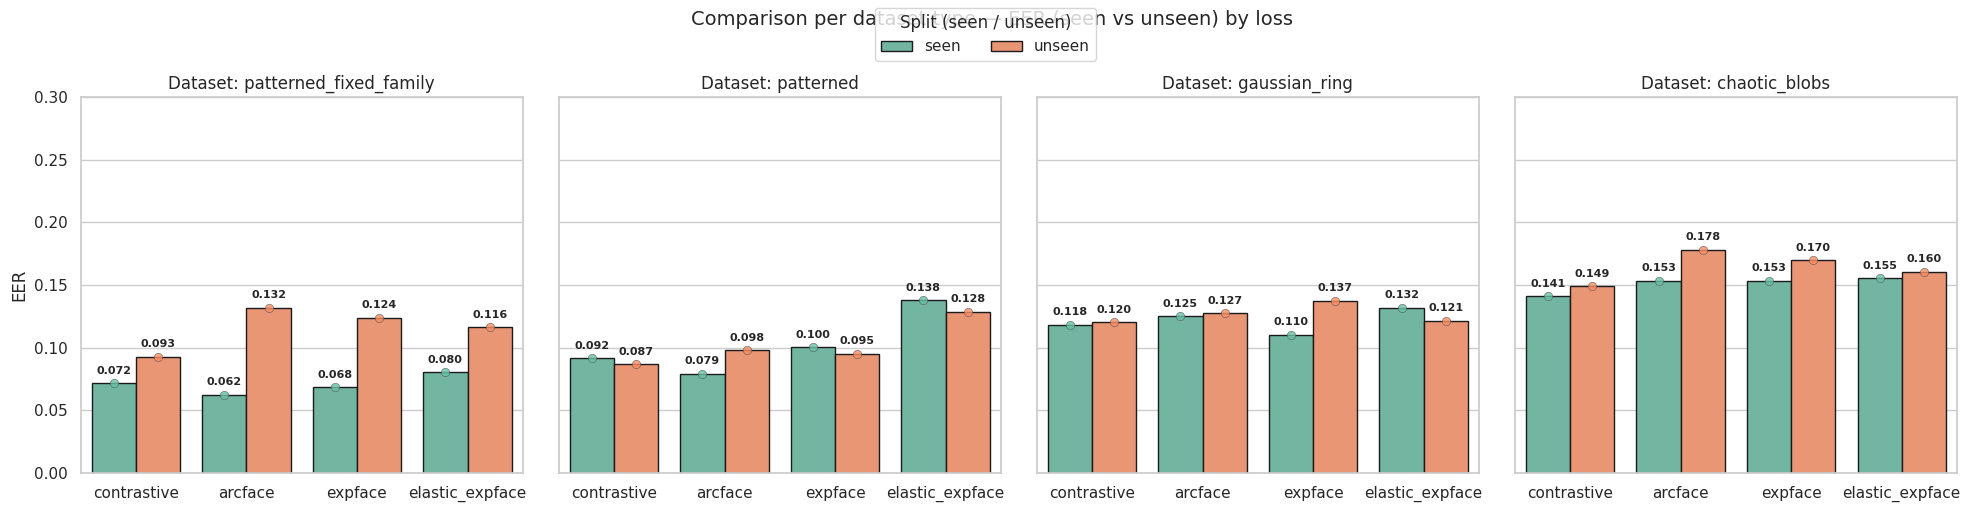

In [ ]:
# %% 
# Plot: um gráfico para cada dataset type, comparando seen vs unseen por loss
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_side_by_side_seen_unseen(df: pd.DataFrame, dataset_types=None,
                                  fixed_ylim=(0.0, 0.6), figsize=(20,5)):
    """
    df: DataFrame with columns ['loss','dataset_type','eer_ss','eer_uu', ...]
    dataset_types: tuple/list of dataset_type values to plot. If None, plots all unique types found.
    fixed_ylim: tuple (ymin, ymax) for all plots
    """
    if dataset_types is None:
        dataset_types = df['dataset_type'].unique()
        
    n_plots = len(dataset_types)
    sns.set(style='whitegrid', font_scale=1.0)
    fig, axes = plt.subplots(1, n_plots, figsize=figsize, sharey=True)
    if n_plots == 1: axes = [axes]
    
    # prepare melted data: each row -> (loss, dataset_type, split('seen'/'unseen'), eer)
    df_melt_rows = []
    for _, row in df.iterrows():
        df_melt_rows.append({'loss': row['loss'], 'dataset_type': row['dataset_type'], 'split': 'seen', 'eer': row['eer_ss']})
        df_melt_rows.append({'loss': row['loss'], 'dataset_type': row['dataset_type'], 'split': 'unseen', 'eer': row['eer_uu']})
    df_melt = pd.DataFrame(df_melt_rows)
    
    palette = sns.color_palette("Set2", 2)  # seen/unseen colors
    
    for ax, dset in zip(axes, dataset_types):
        sub = df_melt[df_melt['dataset_type'] == dset]
        if sub.empty:
            ax.text(0.5,0.5, f'No data for "{dset}"', ha='center', va='center')
            ax.set_title(dset)
            continue
        # barplot (mean ± sd)
        sns.barplot(data=sub, x='loss', y='eer', hue='split', ax=ax, ci='sd', palette=palette, edgecolor='k', capsize=0.08)
        # overlay stripplot for individual points (jitter to show distribution)
        sns.stripplot(data=sub, x='loss', y='eer', hue='split', ax=ax, dodge=True, palette=palette, 
                      marker='o', size=6, linewidth=0.5, edgecolor='gray', alpha=0.8)
        # remove duplicate legend entries (one combined legend)
        handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().remove()
        ax.set_title(f'Dataset: {dset}')
        ax.set_ylim(*fixed_ylim)
        ax.set_xlabel('')
        ax.set_ylabel('EER')
        # show mean values on top of bars
        means = sub.groupby(['loss','split'])['eer'].mean().unstack()
        # annotate means
        xticks = np.arange(len(sub['loss'].unique()))
        losses_order = [t.get_text() for t in ax.get_xticklabels()]
        for i, loss_name in enumerate(losses_order):
            for j, split in enumerate(['seen','unseen']):
                try:
                    mean_val = means.loc[loss_name, split]
                    # x position: bar positions come as i +/- offset (approx)
                    offset = (-0.2 if split == 'seen' else 0.2)
                    ax.text(i + offset, mean_val + (fixed_ylim[1]-fixed_ylim[0])*0.02, f'{mean_val:.3f}', 
                            ha='center', va='bottom', fontsize=8, fontweight='semibold')
                except Exception:
                    pass

    # unified legend (from created handles)
    # recreate legend manually
    fig.legend(handles[:2], labels[:2], loc='upper center', ncol=2, title='Split (seen / unseen)')
    plt.suptitle('Comparison per dataset type — EER (seen vs unseen) by loss', y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

# Usage:
# supondo que já exista `df` (DataFrame retornado por results_to_dataframe)
plot_side_by_side_seen_unseen(df, dataset_types=('patterned_fixed_family','patterned', 'gaussian_ring', 'chaotic_blobs'), fixed_ylim=(0.0,0.3))

In [ ]:
# %%
# --- Célula de Diagnóstico: Investigação do Fenômeno Seen vs Unseen ---
def analyze_seen_unseen_anomaly():
    print("--- Investigação de Anomalia: Seen vs Unseen ---")
    
    # 1. Configuração Fixa
    ds_cfg = {
        'type': 'patterned',
        'n_classes': 12,
        'samples_per_class': 120,
        'radius': 8.0,
        'pattern_types': ['rings','spokes','grid','ellipse'],
        'outlier_frac': 0.04
    }
    # Seed fixa para garantir reprodutibilidade do split
    rng_seed = 42
    
    # 2. Gerar Dados
    print("Gerando dados...")
    X_all, y_all = make_patterned_clusters(
        n_classes=ds_cfg['n_classes'],
        samples_per_class=ds_cfg['samples_per_class'],
        radius=ds_cfg['radius'],
        pattern='varied',
        pattern_types=ds_cfg['pattern_types'],
        separation_noise=0.15,
        outlier_frac=ds_cfg['outlier_frac'],
        rng_seed=rng_seed
    )
    
    # 3. Split Seen/Unseen
    n_classes = int(len(np.unique(y_all)))
    classes = np.arange(n_classes)
    np.random.seed(rng_seed)
    np.random.shuffle(classes)
    n_seen = max(1, int(0.6 * n_classes))
    seen = sorted(classes[:n_seen].tolist())
    unseen = sorted(classes[n_seen:].tolist())
    
    print(f"Classes Vistas (Seen): {seen}")
    print(f"Classes Não-Vistas (Unseen): {unseen}")
    
    # Helper para avaliar um conjunto de features já extraídas
    def eval_features(features, label_desc):
        # Gera pares usando as features fornecidas (seja raw ou embedding)
        groups = make_eval_pairs_zero_shot(features, y_all, seen, unseen, n_pairs_each_group=1000, rng_seed=rng_seed)
        (X1_ss, X2_ss, y_ss), (X1_uu, X2_uu, y_uu), _ = groups
        
        # Cosine Similarity
        def cos_sim(a, b):
            # normaliza e faz dot product
            an = a / (np.linalg.norm(a, axis=1, keepdims=True) + 1e-9)
            bn = b / (np.linalg.norm(b, axis=1, keepdims=True) + 1e-9)
            return np.sum(an * bn, axis=1)
            
        s_ss = cos_sim(X1_ss, X2_ss)
        s_uu = cos_sim(X1_uu, X2_uu)
        
        eer_ss, _, _, _, _ = compute_eer(y_ss, s_ss)
        eer_uu, _, _, _, _ = compute_eer(y_uu, s_uu)
        print(f"[{label_desc:20s}] EER Seen: {eer_ss:.4f} | EER Unseen: {eer_uu:.4f}")

    # A. Baseline: Dados Brutos (2D)
    # Nota: Cosine em 2D pode ser estranho se os dados não estiverem centrados na origem, 
    # mas nossos clusters estão em um círculo ao redor da origem, então faz sentido.
    eval_features(X_all, "Raw Data (2D)")
    
    # B. Baseline: Encoder Não-Treinado (Random Init)
    enc = SimpleEncoder(in_dim=2, emb_dim=16).to(device)
    enc.eval()
    with torch.no_grad():
        X_tensor = torch.from_numpy(X_all).to(device)
        X_untrained = enc(X_tensor).cpu().numpy()
    eval_features(X_untrained, "Untrained Encoder")
    
    # C. Encoder Treinado (ExpFace)
    train_mask = np.isin(y_all, seen)
    X_tr = X_all[train_mask]
    y_tr = y_all[train_mask]
    remap = {c: i for i, c in enumerate(seen)}
    y_tr_remap = np.array([remap[int(v)] for v in y_tr], dtype=np.int64)
    
    print("Treinando (ExpFace)...")
    # Reinicia encoder para garantir treino do zero
    enc = SimpleEncoder(in_dim=2, emb_dim=16).to(device)
    enc, _, _, _ = train_classification(
        encoder=enc,
        loss_name='expface',
        X_tr=X_tr,
        y_tr=y_tr_remap,
        epochs=30,
        verbose=False
    )
    
    enc.eval()
    with torch.no_grad():
        X_trained = enc(X_tensor).cpu().numpy()
    eval_features(X_trained, "Trained Encoder")

analyze_seen_unseen_anomaly()

--- Investigação de Anomalia: Seen vs Unseen ---
Gerando dados...
Classes Vistas (Seen): [0, 1, 2, 5, 8, 9, 10]
Classes Não-Vistas (Unseen): [3, 4, 6, 7, 11]
[Raw Data (2D)       ] EER Seen: 0.0700 | EER Unseen: 0.0480
[Untrained Encoder   ] EER Seen: 0.0860 | EER Unseen: 0.0780
Treinando (ExpFace)...
[Untrained Encoder   ] EER Seen: 0.0860 | EER Unseen: 0.0780
Treinando (ExpFace)...
[Trained Encoder     ] EER Seen: 0.0660 | EER Unseen: 0.0920
[Trained Encoder     ] EER Seen: 0.0660 | EER Unseen: 0.0920


In [ ]:
# %%
# --- Visualization of Predicted Classes (2D) ---
# This cell visualizes the decision boundaries by predicting classes for all points (Seen & Unseen)
# based on the prototypes learned by the Metric Loss (e.g., ExpFace).

print("Visualizing Predicted Classes in Embedding Space...")

# 1. Re-generate Data (Same as analyze_seen_unseen_anomaly)
# We reuse the global variables if they exist from the previous run, otherwise we regenerate.
if 'X_all' not in locals() or 'y_all' not in locals():
    print("Regenerating data...")
    X_all, y_all = make_patterned_clusters(n_classes=10, samples_per_class=150, pattern='varied', rng_seed=SEED)

# 2. Split Seen/Unseen
n_classes = int(len(np.unique(y_all)))
classes = np.arange(n_classes)
np.random.seed(SEED)
np.random.shuffle(classes)
n_seen = max(1, int(0.6 * n_classes))
seen = sorted(classes[:n_seen].tolist())
unseen = sorted(classes[n_seen:].tolist())

# 3. Train Model (ExpFace)
train_mask = np.isin(y_all, seen)
X_tr = X_all[train_mask]
y_tr = y_all[train_mask]
remap = {c: i for i, c in enumerate(seen)}
inv_remap = {i: c for c, i in remap.items()}
y_tr_remap = np.array([remap[int(v)] for v in y_tr], dtype=np.int64)

print(f"Training ExpFace on {len(seen)} classes...")
enc = SimpleEncoder(in_dim=2, emb_dim=16).to(device)
enc, loss_mod, clf, _ = train_classification(
    encoder=enc,
    loss_name='expface',
    X_tr=X_tr,
    y_tr=y_tr_remap,
    epochs=30,
    verbose=False
)

# 4. Predict
enc.eval()
with torch.no_grad():
    X_tensor = torch.from_numpy(X_all).to(device)
    embeddings = enc(X_tensor)
    
    # Get Prototypes (Weights)
    if clf is not None:
        prototypes = clf.weight # (NumClasses, EmbDim)
    elif hasattr(loss_mod, 'weight'):
        prototypes = loss_mod.weight
    else:
        # Fallback: Compute centroids manually
        print("Computing centroids manually...")
        prototypes = []
        for i in range(len(seen)):
            mask = (y_tr_remap == i)
            centroid = embeddings[train_mask][mask].mean(dim=0)
            prototypes.append(centroid)
        prototypes = torch.stack(prototypes)

    # Normalize for Cosine Similarity
    embeddings_norm = F.normalize(embeddings, p=2, dim=1)
    prototypes_norm = F.normalize(prototypes, p=2, dim=1)
    
    # Similarity: (N, EmbDim) @ (EmbDim, NumClasses) -> (N, NumClasses)
    scores = torch.mm(embeddings_norm, prototypes_norm.t())
    preds_idx = torch.argmax(scores, dim=1).cpu().numpy()
    
    # Map back to original class IDs (for Seen classes)
    # Unseen classes will be mapped to the nearest Seen class
    preds_original = np.array([inv_remap[idx] for idx in preds_idx])

# 5. Plot
# Project to 2D for visualization (t-SNE)
from sklearn.manifold import TSNE
print("Projecting to 2D (t-SNE)...")
tsne = TSNE(n_components=2, random_state=SEED)
X_2d = tsne.fit_transform(embeddings.cpu().numpy())

plt.figure(figsize=(12, 6))

# Plot 1: Ground Truth
plt.subplot(1, 2, 1)
# Seen classes
mask_seen = np.isin(y_all, seen)
plt.scatter(X_2d[mask_seen, 0], X_2d[mask_seen, 1], c=y_all[mask_seen], cmap='tab10', label='Seen', alpha=0.6)
# Unseen classes (marked differently)
plt.scatter(X_2d[~mask_seen, 0], X_2d[~mask_seen, 1], c=y_all[~mask_seen], cmap='tab10', marker='x', label='Unseen', alpha=0.6)
plt.title("Ground Truth Classes\n(Circles=Seen, Crosses=Unseen)")
plt.legend()

# Plot 2: Predicted Classes
plt.subplot(1, 2, 2)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=preds_original, cmap='tab10', alpha=0.6)
plt.title("Predicted Classes (Nearest Prototype)\n(Unseen points mapped to nearest Seen class)")

plt.tight_layout()
plt.show()

Visualizing Predicted Classes in Embedding Space...
Regenerating data...


NameError: name 'make_patterned_clusters' is not defined